# Clustering Analysis: Mental Health in Tech 2016

## 1. Load Reduced Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

RUN = 'run_01'

data_dir = f'../../data/{RUN}/reduced'
methods = ['pca', 'mds', 'lle', 'tsne', 'umap']

reduced_data = {}
for method in methods:
    filepath = f'{data_dir}/{method}_2d.csv'
    reduced_data[method] = pd.read_csv(filepath)

## 2. Determining the optimal number of clusters

In [4]:
def plot_cluster_evaluation(data, method_name, k_range=range(2, 11)):
    inertias = []
    silhouettes = []
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(data)
        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(data, labels))
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'{method_name.upper()}', fontsize=14, fontweight='bold')
    
    axes[0].plot(list(k_range), inertias, 'bo-', linewidth=2, markersize=8)
    axes[0].set_xlabel('k')
    axes[0].set_ylabel('Inertia')
    axes[0].set_title('Elbow Method')
    axes[0].set_xticks(list(k_range))
    
    axes[1].plot(list(k_range), silhouettes, 'go-', linewidth=2, markersize=8)
    axes[1].set_xlabel('k')
    axes[1].set_ylabel('Silhouette Score')
    axes[1].set_title('Silhouette Analysis')
    axes[1].set_xticks(list(k_range))
    
    plt.tight_layout()
    plt.show()

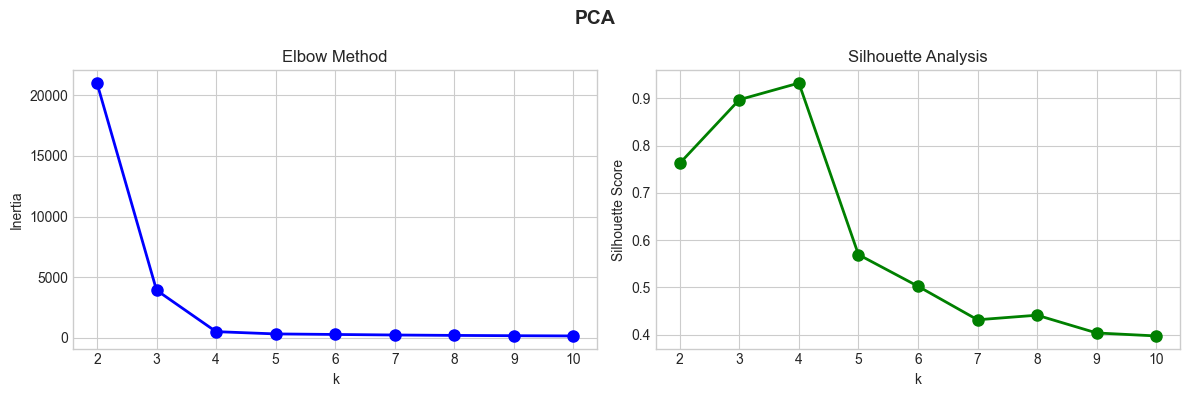

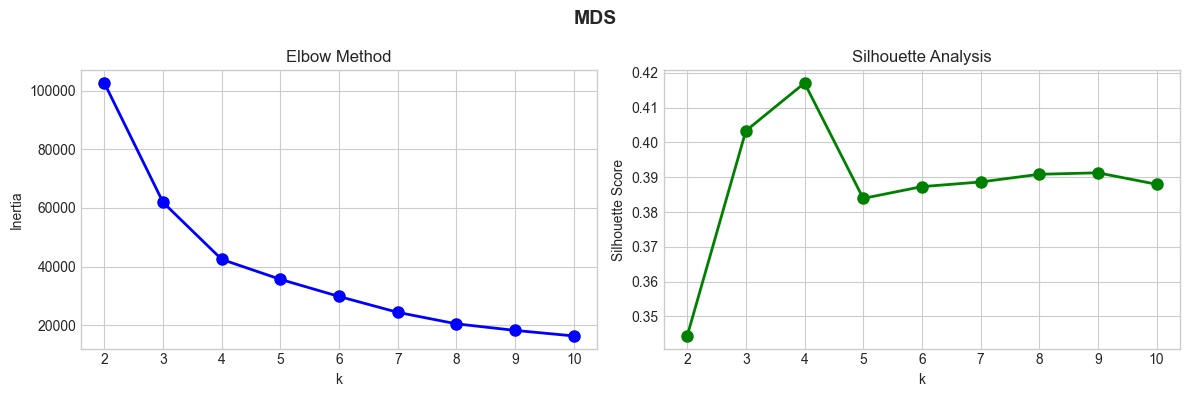

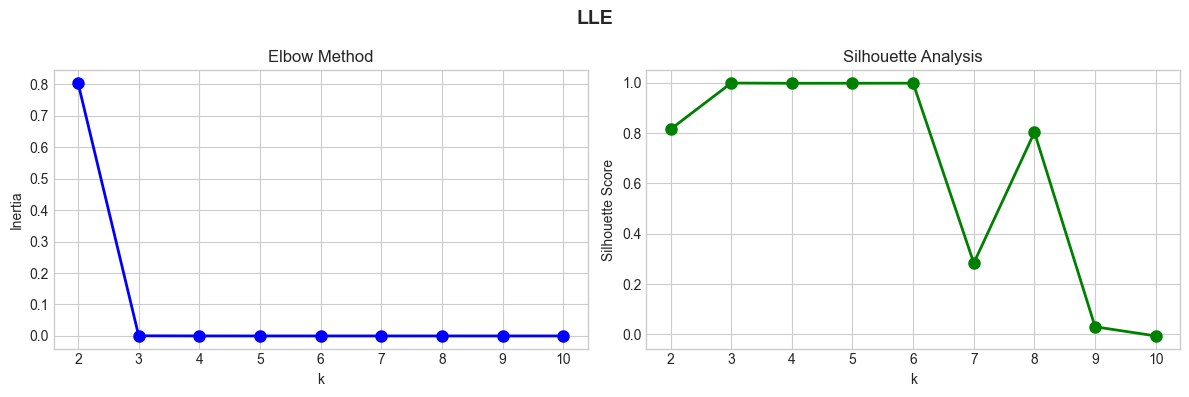

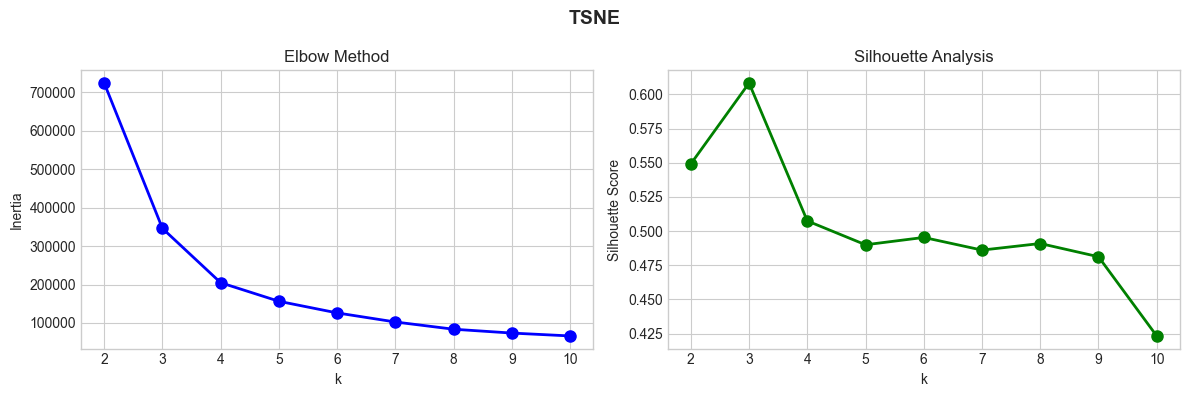

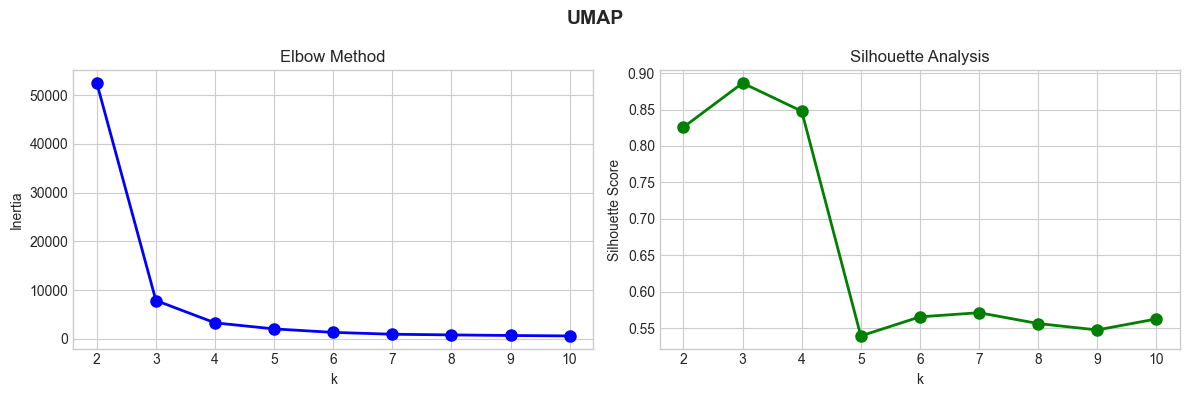

In [5]:
for method in methods:
    plot_cluster_evaluation(reduced_data[method].values, method)

## 3. k-Means Clustering

In [ ]:
K_CLUSTERS = 3

kmeans_results = {}
for method in methods:
    data = reduced_data[method].values
    kmeans = KMeans(n_clusters=K_CLUSTERS, random_state=42, n_init=10)
    labels = kmeans.fit_predict(data)
    kmeans_results[method] = {
        'labels': labels,
        'centroids': kmeans.cluster_centers_,
        'silhouette': silhouette_score(data, labels)
    }

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, method in enumerate(methods):
    ax = axes[idx]
    data = reduced_data[method].values
    labels = kmeans_results[method]['labels']
    centroids = kmeans_results[method]['centroids']
    
    ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10', alpha=0.6, s=20)
    ax.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='X', s=200, edgecolors='white', linewidths=2)
    ax.set_title(f'{method.upper()} (Silhouette: {kmeans_results[method]["silhouette"]:.3f})')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')

axes[5].axis('off')
plt.suptitle(f'k-Means Clustering (k={K_CLUSTERS})', fontsize=14, fontweight='bold')
plt.tight_layout()
os.makedirs(f'../../plots/{RUN}', exist_ok=True)
plt.savefig(f'../../plots/{RUN}/kmeans_clustering.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Gaussian Mixture Model (GMM) Clustering

In [ ]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax, n_std=2.0, **kwargs):
    U, s, _ = np.linalg.svd(covariance)
    angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
    width, height = 2 * n_std * np.sqrt(s)
    ellipse = Ellipse(position, width, height, angle=angle, **kwargs)
    ax.add_patch(ellipse)

gmm_results = {}
for method in methods:
    data = reduced_data[method].values
    gmm = GaussianMixture(n_components=K_CLUSTERS, random_state=42)
    labels = gmm.fit_predict(data)
    gmm_results[method] = {
        'labels': labels,
        'means': gmm.means_,
        'covariances': gmm.covariances_,
        'silhouette': silhouette_score(data, labels)
    }

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, method in enumerate(methods):
    ax = axes[idx]
    data = reduced_data[method].values
    labels = gmm_results[method]['labels']
    means = gmm_results[method]['means']
    covs = gmm_results[method]['covariances']
    
    ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10', alpha=0.6, s=20)
    for i in range(K_CLUSTERS):
        draw_ellipse(means[i], covs[i], ax, n_std=2.0, alpha=0.2, facecolor=plt.cm.tab10(i), edgecolor='black', linewidth=2)
    ax.scatter(means[:, 0], means[:, 1], c='black', marker='X', s=200, edgecolors='white', linewidths=2)
    ax.set_title(f'{method.upper()} (Silhouette: {gmm_results[method]["silhouette"]:.3f})')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')

axes[5].axis('off')
plt.suptitle(f'GMM Clustering (k={K_CLUSTERS})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'../../plots/{RUN}/gmm_clustering.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Hierarchical Clustering

In [ ]:
sample_size = 200
np.random.seed(42)
sample_idx = np.random.choice(len(reduced_data['pca']), sample_size, replace=False)
sample_data = reduced_data['pca'].values[sample_idx]

linkage_matrix = linkage(sample_data, method='ward')

fig, ax = plt.subplots(figsize=(14, 5))
dendrogram(linkage_matrix, ax=ax, truncate_mode='lastp', p=30, leaf_rotation=90, leaf_font_size=8)
ax.set_title('Dendrogram (Ward Method, PCA Data, n=200)')
ax.set_xlabel('Cluster')
ax.set_ylabel('Distance')
ax.axhline(y=15, color='r', linestyle='--', alpha=0.7, label=f'Cut for k={K_CLUSTERS}')
ax.legend()
plt.tight_layout()
plt.savefig(f'../../plots/{RUN}/dendrogram.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
hierarchical_results = {}
for method in methods:
    data = reduced_data[method].values
    agg = AgglomerativeClustering(n_clusters=K_CLUSTERS, linkage='ward')
    labels = agg.fit_predict(data)
    hierarchical_results[method] = {
        'labels': labels,
        'silhouette': silhouette_score(data, labels)
    }

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, method in enumerate(methods):
    ax = axes[idx]
    data = reduced_data[method].values
    labels = hierarchical_results[method]['labels']
    
    ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10', alpha=0.6, s=20)
    for i in range(K_CLUSTERS):
        cluster_points = data[labels == i]
        centroid = cluster_points.mean(axis=0)
        ax.scatter(centroid[0], centroid[1], c='black', marker='X', s=200, edgecolors='white', linewidths=2)
    ax.set_title(f'{method.upper()} (Silhouette: {hierarchical_results[method]["silhouette"]:.3f})')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')

axes[5].axis('off')
plt.suptitle(f'Hierarchical Clustering - Ward (k={K_CLUSTERS})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'../../plots/{RUN}/hierarchical_clustering.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Save Results

In [ ]:
output_dir = f'../../data/{RUN}/clustered'
os.makedirs(output_dir, exist_ok=True)

df_preprocessed = pd.read_csv(f'../../data/{RUN}/processed/mental_health_preprocessed.csv')

best_score = -1
best_labels = None
best_method = None
best_algorithm = None

for method in methods:
    for algo_name, results in [('kmeans', kmeans_results), ('gmm', gmm_results), ('hierarchical', hierarchical_results)]:
        score = results[method]['silhouette']
        if score > best_score:
            best_score = score
            best_labels = results[method]['labels']
            best_method = method
            best_algorithm = algo_name

df_clustered = df_preprocessed.copy()
df_clustered['cluster'] = best_labels

df_clustered.to_csv(f'{output_dir}/clustered_data.csv', index=False)